In [3]:
# settings
%matplotlib inline
from pyvista import set_plot_theme
set_plot_theme('document')

# importing required packages
import gempy as gp
import pyvista as pv
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
from scipy import stats

pd.set_option('precision', 2)

In [4]:
# Load data for simple fold model from gempy
data_path = 'https://raw.githubusercontent.com/cgre-aachen/gempy_data/master/'
path_to_data = data_path + "/data/input_data/jan_models/"

data_surfaces = pd.read_csv(
    'https://raw.githubusercontent.com/cgre-aachen/gempy_data/master/data/input_data/jan_models/model2_surface_points.csv')

### 1) Model with regularly spaced data (Fig. 5)

In [5]:
# create gempy model
geo_data = gp.create_data('fold', extent=[0, 1000, 0, 1000, 0, 1000], resolution=[50, 50, 50],
                          path_o=path_to_data + "model2_orientations.csv",
                          path_i=path_to_data + "model2_surface_points.csv")

# set stratigraphic pile
gp.map_stack_to_surfaces(geo_data, {"Strat_Series": ('rock2', 'rock1'), "Basement_Series": ('basement')})

# define required cross sections
section_dict = {'section1': ([200, 0], [200, 1000], [50, 50])} 
geo_data.set_section_grid(section_dict)

# set interpolator
interp_data = gp.set_interpolator(geo_data, theano_optimizer='fast_compile')

# compute solution
sol = gp.compute_model(geo_data)

Active grids: ['regular']
Active grids: ['regular' 'sections']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            1.7e+03
$C_o$            7.1e+04
drift equations   [3, 3]


In [6]:
# 3D model for figure 5 (a)
vertices = data_surfaces.values[:,:3].astype("float")
mesh = pv.PolyData(vertices)

gpv = gp.plot_3d(geo_data, show_lith=True, show_surfaces=True, plotter_type="background")

gpv.p.add_mesh(mesh, color="black", render_points_as_spheres=True, point_size=15)
gpv.p.show_grid()

gpv.p.camera_position = (-10, 10, 5)
gpv.p.show()

C:\Users\vonha\miniconda3\envs\gemtools\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


Text(0.5, 1.0, '(c) Section at y = 500')

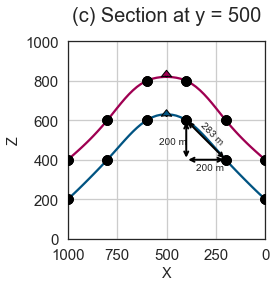

In [7]:
# create figure 5 (b)
p = gp.plot_2d(geo_data, cell_number=25,
           direction='y', show_data=True, show_lith=False, legend=False)

p.axes[0].scatter(geo_data.surface_points.df["X"][:],
                  geo_data.surface_points.df["Z"][:], marker='o', s=100, color="black", zorder=10000)

p.axes[0].annotate(text ='', xy=(400,600), xytext=(200,400), 
                   arrowprops=dict(arrowstyle='<->', facecolor='black', lw=2), zorder=1000)
p.axes[0].annotate(text ='', xy=(400,400), xytext=(200,400), 
                   arrowprops=dict(arrowstyle='<->', facecolor='black', lw=2), zorder=1000)
p.axes[0].annotate(text ='', xy=(400,600), xytext=(400,400), 
                   arrowprops=dict(arrowstyle='<->', facecolor='black', lw=2), zorder=1000)

p.axes[0].annotate(text ='200 m', xy=(250,250), xytext=(350,350))
p.axes[0].annotate(text ='200 m', xy=(250,250), xytext=(540,480))
p.axes[0].annotate(text ='283 m', xy=(250,250), xytext=(340,480), rotation=-45)

p.axes[0].grid()

p.axes[0].set_xlim(1000, 0)

p.axes[0].tick_params(axis='both', which='major', labelsize=15)
p.axes[0].set_title("(c) Section at y = 500", fontsize=20, pad=20)


(1000.0, 0.0)

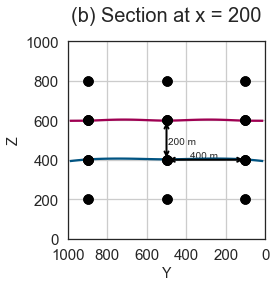

In [8]:
# create figure 5 (c)
p = gp.plot_2d(geo_data, section_names=['section1'], show_lith=False, show_data=False)

p.axes[0].set_xticks(np.arange(0,1001,200))
p.axes[0].set_xticklabels(np.arange(0,1001,200), rotation=0)

p.axes[0].scatter(geo_data.surface_points.df["Y"][:],
                  geo_data.surface_points.df["Z"][:], marker='o', s=100, color="black", zorder=10000)


p.axes[0].annotate(text ='', xy=(500,400), xytext=(100,400), 
                   arrowprops=dict(arrowstyle='<->', facecolor='black', lw=2), zorder=1000)
p.axes[0].annotate(text ='', xy=(500,600), xytext=(500,400), 
                   arrowprops=dict(arrowstyle='<->', facecolor='black', lw=2), zorder=1000)

p.axes[0].annotate(text ='400 m', xy=(250,250), xytext=(380,410))
p.axes[0].annotate(text ='200 m', xy=(250,250), xytext=(490,480))

p.axes[0].grid()

p.axes[0].tick_params(axis='both', which='major', labelsize=15)
p.axes[0].set_title("(b) Section at x = 200", fontsize=20, pad=20)

p.axes[0].set_xlim(1000, 0)

### 2) Model with random noise (original)

In [9]:
# standard deviation for random noise
std = 25

# mapping between scalar field and real space based on model with regularly spaced data
smoothing = (sol.scalar_field_matrix.max()-sol.scalar_field_matrix.min())/1000*(std**2)

# load original data
data_surfaces1 = pd.read_csv(
    'https://raw.githubusercontent.com/cgre-aachen/gempy_data/master/data/input_data/jan_models/model2_surface_points.csv')

# define noise
noise = np.random.normal(0, std, size=50)

# create noisy data around fold limbs
x_1 = np.random.randint(0,400,25)
x_2 = np.random.randint(600,1000,25)
x = np.hstack((x_1, x_2))
z_1 = 400 + x_1 
z_2 = 1400 - x_2 
z = np.hstack((z_1, z_2))
z = z + noise
y = np.random.randint(0,1000,50)

# add to dataframe for gempy input
for i in range(50):
    df = pd.DataFrame([[x[i], y[i], z[i], 'rock2']], 
                  columns=("X", "Y", "Z", "formation"))

    data_surfaces1 = data_surfaces1.append(df)
    
# saved only once for paper version
# data_surfaces1.to_csv("surfaces_random_noise.csv", index=False)

In [10]:
# create gempy model
geo_data = gp.create_data('fold', extent=[0, 1000, 0, 1000, 0, 1000], resolution=[50, 50, 50],
                          path_o=path_to_data+"model2_orientations.csv",
                          path_i="surfaces_random_noise.csv")

# set stratigraphic pile
gp.map_stack_to_surfaces(geo_data, {"Strat_Series": ('rock2', 'rock1'), "Basement_Series": ('basement')})

# zero local smoothing/nugget
geo_data.surface_points.df["smooth"]=0

# define required cross sections
section_dict = {'section1': ([200, 0], [200, 1000], [50, 50])} 
geo_data.set_section_grid(section_dict)

# set interpolator
interp_data = gp.set_interpolator(geo_data, theano_optimizer='fast_compile')

# compute solution
sol = gp.compute_model(geo_data)

Active grids: ['regular']
Active grids: ['regular' 'sections']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            1.7e+03
$C_o$            7.1e+04
drift equations   [3, 3]


In [11]:
# 3D model for figure 6 (a)
vertices = data_surfaces.values[:,:3].astype("float")
mesh = pv.PolyData(vertices)

vertices2 = data_surfaces1.values[:,:3].astype("float")
mesh2 = pv.PolyData(vertices2)

gpv = gp.plot_3d(geo_data, show_lith=True, show_surfaces=True, plotter_type="background")

gpv.p.add_mesh(mesh, color="black", render_points_as_spheres=True, point_size=15)
gpv.p.show_grid()

gpv.p.camera_position = (-10,10,5)

gpv.p.show()

C:\Users\vonha\miniconda3\envs\gemtools\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


Text(0.5, 1.0, '(c) Section at y = 500')

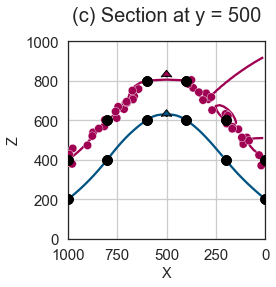

In [12]:
# create figure 6 (b)
p = gp.plot_2d(geo_data, cell_number=25,
           direction='y', show_data=True, show_lith=False, legend=False)

p.axes[0].grid()

p.axes[0].set_xlim(1000, 0)

p.axes[0].scatter(geo_data.surface_points.df["X"][:18], 
                  geo_data.surface_points.df["Z"][:18], marker='o', s=100, color="black", zorder=10000)

p.axes[0].scatter(geo_data.surface_points.df["X"][68:], 
                  geo_data.surface_points.df["Z"][68:], marker='o', s=100, color="black", zorder=10000)

p.axes[0].tick_params(axis='both', which='major', labelsize=15)
p.axes[0].set_title("(c) Section at y = 500", fontsize=20, pad=20)


C:\Users\vonha\miniconda3\envs\gemtools\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


(1000.0, 0.0)

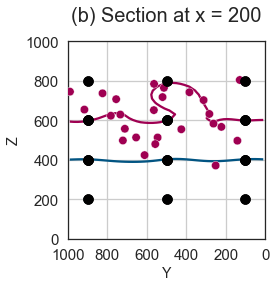

In [13]:
# create figure 6 (c)
p = gp.plot_2d(geo_data, section_names=['section1'], show_lith=False, show_data=True, legend=False)

p.axes[0].set_xticks(np.arange(0,1001,200))
p.axes[0].set_xticklabels(np.arange(0,1001,200), rotation=0)
p.axes[0].grid()

p.axes[0].scatter(geo_data.surface_points.df["Y"][:18],
                  geo_data.surface_points.df["Z"][:18], marker='o', s=100, color="black", zorder=10000)

p.axes[0].scatter(geo_data.surface_points.df["Y"][68:], 
                  geo_data.surface_points.df["Z"][68:], marker='o', s=100, color="black", zorder=10000)

p.axes[0].tick_params(axis='both', which='major', labelsize=15)
p.axes[0].set_title("(b) Section at x = 200", fontsize=20, pad=20)

p.axes[0].set_xlim(1000, 0)


### 3) Model with random noise (smoothed)

In [14]:
# create gempy model
geo_data = gp.create_data('fold', extent=[0, 1000, 0, 1000, 0, 1000], resolution=[50, 50, 50],
                          path_o=path_to_data+"model2_orientations.csv",
                          path_i="surfaces_random_noise.csv")

# set stratigraphic pile
gp.map_stack_to_surfaces(geo_data, {"Strat_Series": ('rock2', 'rock1'), "Basement_Series": ('basement')})

# data informed local smoothing, manually fixed here
geo_data.surface_points.df["smooth"]=smoothing

# define required cross sections
section_dict = {'section1': ([200, 0], [200, 1000], [50, 50])} 
geo_data.set_section_grid(section_dict)

# set interpolator
interp_data = gp.set_interpolator(geo_data, theano_optimizer='fast_compile')

# compute solution
sol = gp.compute_model(geo_data)

Active grids: ['regular']
Active grids: ['regular' 'sections']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            1.7e+03
$C_o$            7.1e+04
drift equations   [3, 3]


In [15]:
# 3D model for figure 7 (a)
vertices = data_surfaces.values[:,:3].astype("float")
mesh = pv.PolyData(vertices)

vertices2 = data_surfaces1.values[:,:3].astype("float")
mesh2 = pv.PolyData(vertices2)

gpv = gp.plot_3d(geo_data, show_lith=True, show_surfaces=True, plotter_type="background")

gpv.p.add_mesh(mesh, color="black", render_points_as_spheres=True, point_size=15)
gpv.p.show_grid()

gpv.p.camera_position = (-10,10,5)

gpv.p.show()

C:\Users\vonha\miniconda3\envs\gemtools\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


Text(0.5, 1.0, '(c) Section at y = 500')

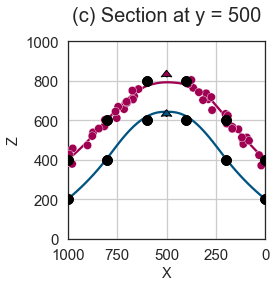

In [16]:
# create figure 7 (b)
p = gp.plot_2d(geo_data, cell_number=25,
           direction='y', show_data=True, show_lith=False, legend=False)

p.axes[0].grid()

p.axes[0].set_xlim(1000, 0)

p.axes[0].scatter(geo_data.surface_points.df["X"][:18], 
                  geo_data.surface_points.df["Z"][:18], marker='o', s=100, color="black", zorder=10000)

p.axes[0].scatter(geo_data.surface_points.df["X"][68:], 
                  geo_data.surface_points.df["Z"][68:], marker='o', s=100, color="black", zorder=10000)

p.axes[0].tick_params(axis='both', which='major', labelsize=15)
p.axes[0].set_title("(c) Section at y = 500", fontsize=20, pad=20)


C:\Users\vonha\miniconda3\envs\gemtools\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


(1000.0, 0.0)

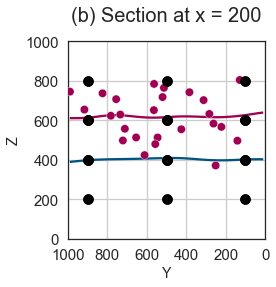

In [17]:
# create figure 7 (c)
p = gp.plot_2d(geo_data, section_names=['section1'], show_lith=False, show_data=True, legend=False)

p.axes[0].set_xticks(np.arange(0,1001,200))
p.axes[0].set_xticklabels(np.arange(0,1001,200), rotation=0)
p.axes[0].grid()

p.axes[0].scatter(geo_data.surface_points.df["Y"][:18],
                  geo_data.surface_points.df["Z"][:18], marker='o', s=100, color="black", zorder=10000)

p.axes[0].scatter(geo_data.surface_points.df["Y"][68:], 
                  geo_data.surface_points.df["Z"][68:], marker='o', s=100, color="black", zorder=10000)

p.axes[0].tick_params(axis='both', which='major', labelsize=15)
p.axes[0].set_title("(b) Section at x = 200", fontsize=20, pad=20)

p.axes[0].set_xlim(1000, 0)


### 4) Model with clustered random noise

In [18]:
# load original data
data_surfaces2 = pd.read_csv(
    'https://raw.githubusercontent.com/cgre-aachen/gempy_data/master/data/input_data/jan_models/model2_surface_points.csv')

# create cluster one
x1 = 200 + np.random.normal(0, std, size=25)
y1 = 500 + np.random.normal(0, std, size=25)
z1 = 600 + np.random.normal(0, std, size=25)

# create cluster 2
x2 = 400 + np.random.normal(0, std, size=25)
y2 = 900 + np.random.normal(0, std, size=25)
z2 = 800 + np.random.normal(0, std, size=25)

# add to dataframe for gempy input
for i in range(25):
    df = pd.DataFrame([[x1[i], y1[i], z1[i], 'rock2']], 
                  columns=("X", "Y", "Z", "formation"))

    data_surfaces2 = data_surfaces2.append(df)
    
for i in range(25):
    df = pd.DataFrame([[x2[i], y2[i], z2[i], 'rock2']], 
                  columns=("X", "Y", "Z", "formation"))

    data_surfaces2 = data_surfaces2.append(df)

# saved only once for paper version
# data_surfaces2.to_csv("surfaces_cluster_noise.csv", index=False)

In [19]:
# create gempy model
geo_data = gp.create_data('fold', extent=[0, 1000, 0, 1000, 0, 1000], resolution=[50, 50, 50],
                          path_o=path_to_data+"model2_orientations.csv",
                          path_i="surfaces_cluster_noise.csv")

# set stratigraphic pile
gp.map_stack_to_surfaces(geo_data, {"Strat_Series": ('rock2', 'rock1'), "Basement_Series": ('basement')})

# zero local smoothing/nugget
geo_data.surface_points.df["smooth"]=0

# define required cross sections
section_dict = {'section1': ([200, 0], [200, 1000], [50, 50])} 
geo_data.set_section_grid(section_dict)

# set interpolator
interp_data = gp.set_interpolator(geo_data, theano_optimizer='fast_compile')

# compute solution
sol = gp.compute_model(geo_data)

Active grids: ['regular']
Active grids: ['regular' 'sections']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            1.7e+03
$C_o$            7.1e+04
drift equations   [3, 3]


In [20]:
# 3D model for figure 8 (a)
gpv = gp.plot_3d(geo_data, show_lith=True, show_surfaces=True, plotter_type="background")

gpv.p.add_mesh(mesh, color="black", render_points_as_spheres=True, point_size=15)
gpv.p.show_grid()

gpv.p.camera_position = (-10,10,5)

gpv.p.show()

C:\Users\vonha\miniconda3\envs\gemtools\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


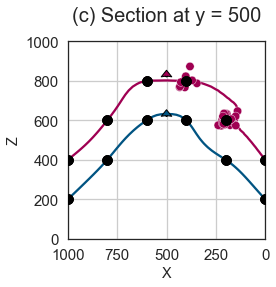

In [21]:
# create figure 8 (b)
p = gp.plot_2d(geo_data, cell_number=25,
           direction='y', show_data=True, show_lith=False, legend=False)

p.axes[0].scatter(geo_data.surface_points.df["X"][:18], 
                  geo_data.surface_points.df["Z"][:18], marker='o', s=100, color="black", zorder=10000)

p.axes[0].scatter(geo_data.surface_points.df["X"][68:], 
                  geo_data.surface_points.df["Z"][68:], marker='o', s=100, color="black", zorder=10000)

p.axes[0].tick_params(axis='both', which='major', labelsize=15)
p.axes[0].set_title("(c) Section at y = 500", fontsize=20, pad=20)

p.axes[0].set_xlim(1000, 0)

p.axes[0].grid()

C:\Users\vonha\miniconda3\envs\gemtools\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


(1000.0, 0.0)

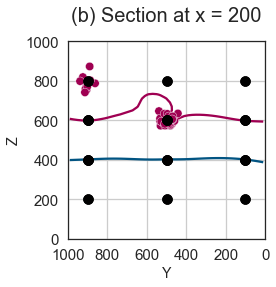

In [22]:
# create figure 8 (c)
p = gp.plot_2d(geo_data, section_names=['section1'], show_lith=False, show_data=True, legend=False)

p.axes[0].set_xticks(np.arange(0,1001,200))
p.axes[0].set_xticklabels(np.arange(0,1001,200), rotation=0)

p.axes[0].grid()

p.axes[0].scatter(geo_data.surface_points.df["Y"][:18],
                  geo_data.surface_points.df["Z"][:18], marker='o', s=100, color="black", zorder=10000)

p.axes[0].scatter(geo_data.surface_points.df["Y"][68:], 
                  geo_data.surface_points.df["Z"][68:], marker='o', s=100, color="black", zorder=10000)

p.axes[0].tick_params(axis='both', which='major', labelsize=15)
p.axes[0].set_title("(b) Section at x = 200", fontsize=20, pad=20)

p.axes[0].set_xlim(1000, 0)


### 5) Model with clustered random noise (KDE informed local smoothing)

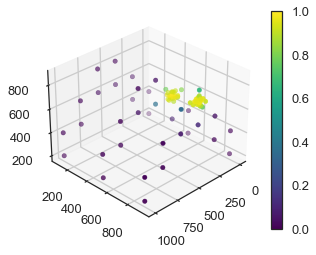

In [101]:
# load data
values = pd.read_csv("surfaces_cluster_noise.csv")
values = values.values[:,:3].T.astype("float64")

# Calculate and plot KDE
kde = stats.gaussian_kde(values)
density = kde(values)

# normalize KDE for scaling to scalar field
density = (density-min(density))/(max(density)-min(density))

# plotting
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
x, y, z = values
cd = ax.scatter(x, y, z, c=density, cmap="viridis")
ax.view_init(elev=30, azim=45)
plt.colorbar(cd)
plt.show()

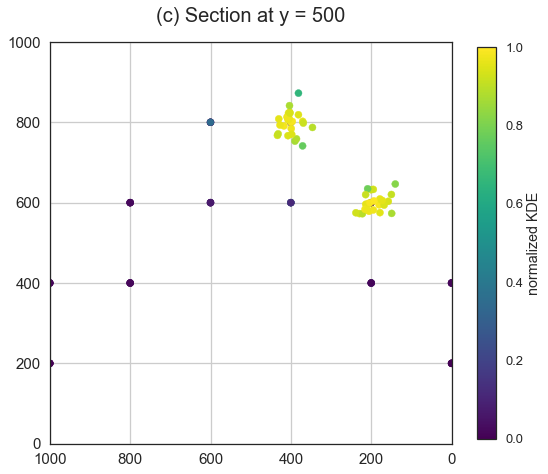

In [102]:
# create figure 9 (a)
plt.figure(figsize=(9, 9))

plt.scatter(x, z, marker='o', s=50, c=density, cmap="viridis")

plt.tick_params(axis='both', which='major', labelsize=15)
plt.title("(c) Section at y = 500", fontsize=20, pad=20)

plt.gca().set_aspect('equal', adjustable='box')

plt.xlim(1000, 0)
plt.ylim(0, 1000)

plt.colorbar(shrink=0.8, label="normalized KDE")

plt.grid()

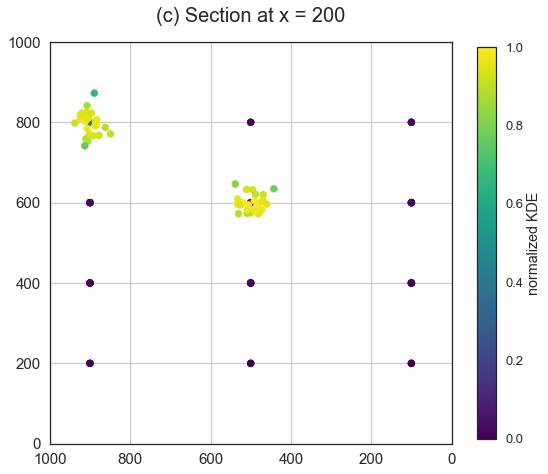

In [103]:
# create figure 9 (c)
plt.figure(figsize=(9, 9))

plt.scatter(y, z, marker='o', s=50, c=density, cmap="viridis")

plt.tick_params(axis='both', which='major', labelsize=15)
plt.title("(c) Section at x = 200", fontsize=20, pad=20)

plt.gca().set_aspect('equal', adjustable='box')

plt.xlim(1000, 0)
plt.ylim(0, 1000)

plt.colorbar(shrink=0.8, label="normalized KDE")

plt.grid()

In [105]:
# create gempy model
geo_data = gp.create_data('fold', extent=[0, 1000, 0, 1000, 0, 1000], resolution=[50, 50, 50],
                          path_o=path_to_data+"model2_orientations.csv",
                          path_i="surfaces_cluster_noise.csv")

# Adding local smoothing
geo_data.surface_points.df["smooth"]=density

# set stratigraphic pile
gp.map_stack_to_surfaces(geo_data, {"Strat_Series": ('rock2', 'rock1'), "Basement_Series": ('basement')})

# define required cross sections
section_dict = {'section1': ([200, 0], [200, 1000], [50, 50])} 
geo_data.set_section_grid(section_dict)

# set interpolator
interp_data = gp.set_interpolator(geo_data, theano_optimizer='fast_compile')

# compute solution
sol = gp.compute_model(geo_data)

Active grids: ['regular']
Active grids: ['regular' 'sections']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            1.7e+03
$C_o$            7.1e+04
drift equations   [3, 3]


In [106]:
# 3D model
gpv = gp.plot_3d(geo_data, show_lith=True, show_surfaces=True, plotter_type="background")

gpv.p.add_mesh(mesh, color="black", render_points_as_spheres=True, point_size=15)
gpv.p.show_grid()

gpv.p.camera_position = (-10,10,5)

gpv.p.show()

C:\Users\vonha\miniconda3\envs\gemtools\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


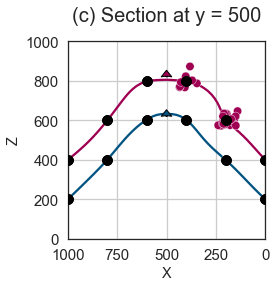

In [107]:
# create figure 9 (c)
p = gp.plot_2d(geo_data, cell_number=25,
           direction='y', show_data=True, show_lith=False, legend=False)

p.axes[0].scatter(geo_data.surface_points.df["X"][:18], 
                  geo_data.surface_points.df["Z"][:18], marker='o', s=100, color="black", zorder=10000)

p.axes[0].scatter(geo_data.surface_points.df["X"][68:], 
                  geo_data.surface_points.df["Z"][68:], marker='o', s=100, color="black", zorder=10000)

p.axes[0].tick_params(axis='both', which='major', labelsize=15)
p.axes[0].set_title("(c) Section at y = 500", fontsize=20, pad=20)

p.axes[0].set_xlim(1000, 0)

p.axes[0].grid()

C:\Users\vonha\miniconda3\envs\gemtools\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


(1000.0, 0.0)

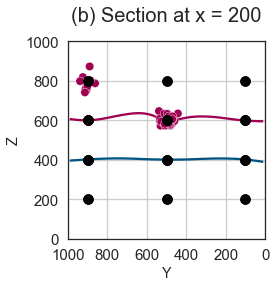

In [108]:
# create figure 9 (d)
p = gp.plot_2d(geo_data, section_names=['section1'], show_lith=False, show_data=True, legend=False)

p.axes[0].set_xticks(np.arange(0,1001,200))
p.axes[0].set_xticklabels(np.arange(0,1001,200), rotation=0)


p.axes[0].grid()

p.axes[0].scatter(geo_data.surface_points.df["Y"][:18],
                  geo_data.surface_points.df["Z"][:18], marker='o', s=100, color="black", zorder=10000)

p.axes[0].scatter(geo_data.surface_points.df["Y"][68:], 
                  geo_data.surface_points.df["Z"][68:], marker='o', s=100, color="black", zorder=10000)

p.axes[0].tick_params(axis='both', which='major', labelsize=15)
p.axes[0].set_title("(b) Section at x = 200", fontsize=20, pad=20)

p.axes[0].set_xlim(1000, 0)
